In [12]:
  import pandas as pd
  import random
  import numpy as np
  import matplotlib.pyplot as plt

 # part_1 : decision tree 

In [13]:
dataset = pd.read_csv("Q1Data.csv")

In [14]:
# Split the data into a 80-20 train-test split
split_ratio = 0.8
split_index = int(len(dataset) * split_ratio)

In [15]:
test = dataset[:split_index]
train = dataset[split_index:]

In [16]:
train_features = train.iloc[:,:6]
train_label = train['Genus']

In [17]:
train_label

5756    Hypsiboas
5757    Hypsiboas
5758    Hypsiboas
5759    Hypsiboas
5760    Hypsiboas
          ...    
7190       Scinax
7191       Scinax
7192       Scinax
7193       Scinax
7194       Scinax
Name: Genus, Length: 1439, dtype: object

In [18]:
test_features = test.iloc[:,:6]
test_label = test['Genus']

In [19]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_labels, counts = np.unique(y, return_counts=True)

        if len(unique_labels) == 1:
            # If all samples have the same label, return that label
            return unique_labels[0]

        if depth == self.max_depth:
            # If maximum depth reached, return the most common label
            return unique_labels[np.argmax(counts)]

        if num_samples <= 1:
            # If only one sample remains, return the label of that sample
            return unique_labels[0]

        # Find the best split point
        best_split = self._find_best_split(X, y)
        if best_split is None:
            return unique_labels[np.argmax(counts)]

        feature_idx, value = best_split
        left_indices = X[:, feature_idx] <= value
        right_indices = X[:, feature_idx] > value

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (feature_idx, value, left_subtree, right_subtree)

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = 1.0
        best_split = None

        for feature_idx in range(num_features):
            unique_values = np.unique(X[:, feature_idx])
            for value in unique_values:
                left_indices = X[:, feature_idx] <= value
                right_indices = X[:, feature_idx] > value
                gini = self._calculate_gini(y[left_indices], y[right_indices])

                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_idx, value)

        return best_split

    def _calculate_gini(self, left_labels, right_labels):
        num_left = len(left_labels)
        num_right = len(right_labels)
        total_samples = num_left + num_right

        if total_samples == 0:
            return 1.0

        p_left = num_left / total_samples
        p_right = num_right / total_samples

        gini_left = 1.0 - sum([(np.sum(left_labels == label) / num_left) ** 2 for label in np.unique(left_labels)])
        gini_right = 1.0 - sum([(np.sum(right_labels == label) / num_right) ** 2 for label in np.unique(right_labels)])

        gini = p_left * gini_left + p_right * gini_right
        return gini

    def predict(self, X):
        return [self._predict_tree(x, self.tree) for x in X]

    def _predict_tree(self, x, node):
        if isinstance(node, tuple):
            feature_idx, value, left_subtree, right_subtree = node
            if x[feature_idx] <= value:
                return self._predict_tree(x, left_subtree)
            else:
                return self._predict_tree(x, right_subtree)
        else:
            return node



In [20]:
train_features = train_features.to_numpy()
train_label = train_label.to_numpy()
test_features = test_features.to_numpy()
test_label = test_label.to_numpy()

In [21]:
tree = DecisionTree(max_depth=5)  

In [22]:
tree.fit(train_features, train_label)

In [24]:
predictions = tree.predict(test_features)


In [25]:
def accuracy(y_true, y_pred):
    correct = sum(y_true == y_pred)
    total = len(y_true)
    return correct / total * 100

In [26]:
accuracy_score = accuracy(test_label, predictions)

In [27]:
accuracy_score

10.284920083391244

In [28]:
accuracy_scores = []
for depth in range(1, 16):
    tree = DecisionTree(max_depth=depth)
    tree.fit(train_features, train_label)
    predictions = tree.predict(test_features)
    accuracy_score = accuracy(test_label, predictions)
    accuracy_scores.append(accuracy_score)

    print(f'Test Accuracy (Depth {depth}): {accuracy_score:.2f}%')



Test Accuracy (Depth 1): 11.99%
Test Accuracy (Depth 2): 10.02%
Test Accuracy (Depth 3): 11.87%
Test Accuracy (Depth 4): 11.85%
Test Accuracy (Depth 5): 10.28%
Test Accuracy (Depth 6): 10.32%
Test Accuracy (Depth 7): 10.67%
Test Accuracy (Depth 8): 10.58%
Test Accuracy (Depth 9): 10.39%
Test Accuracy (Depth 10): 10.39%
Test Accuracy (Depth 11): 10.39%
Test Accuracy (Depth 12): 10.39%
Test Accuracy (Depth 13): 10.39%
Test Accuracy (Depth 14): 10.39%
Test Accuracy (Depth 15): 10.39%


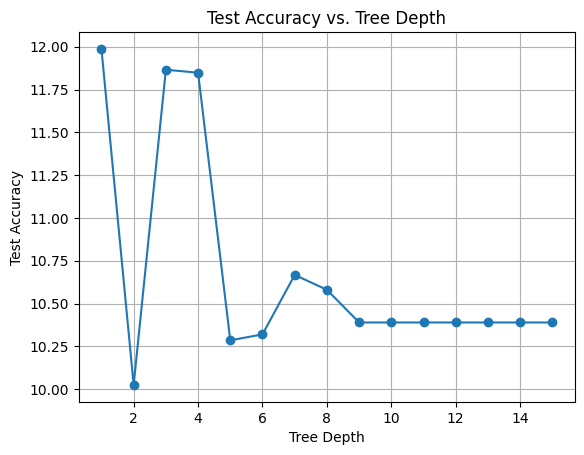

In [29]:
import matplotlib.pyplot as plt

depths = range(1, 16)
plt.plot(depths, accuracy_scores, marker='o')
plt.title('Test Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid()
plt.show()

# part 2 KNN 

In [30]:
import pandas as pd

def split_dataset(df, train_ratio=0.3, test_ratio=0.1):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    
    # Calculate split indices
    train_index = int(len(shuffled_df) * train_ratio)
    test_index = train_index + int(len(shuffled_df) * test_ratio)
    
    # Split the DataFrame
    train_set = shuffled_df.iloc[:train_index]
    test_set = shuffled_df.iloc[train_index:test_index]
    
    return train_set, test_set

# Assuming 'dataset' is a pandas DataFrame
train_knn, test_knn = split_dataset(dataset, train_ratio=0.3, test_ratio=0.1)


In [31]:
len(test_knn)

719

In [32]:
len(dataset)

7195

In [33]:
train_features_knn = train_knn.iloc[:,:21]
train_label_knn = train_knn['Genus']

In [34]:
len(train_label_knn)

2158

In [35]:
test_features_knn = test_knn.iloc[:,:21]
test_label_knn = test_knn['Genus']

In [36]:
len(test_label_knn)

719

In [37]:
train_features_knn = train_features_knn.to_numpy()
train_label_knn = train_label_knn.to_numpy()

test_features_knn = test_features_knn.to_numpy()
test_label_knn = test_label_knn.to_numpy()


In [38]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]
        
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Return the most common class label
        majority_vote = max(set(k_nearest_labels), key=k_nearest_labels.count)
        return majority_vote

In [39]:
knn = KNN(k = 3)

In [40]:
knn.fit(train_features_knn, train_label_knn)

In [41]:
prediction_knn = knn.predict(test_features_knn)

In [42]:
accuracy_knn = accuracy(test_label_knn,prediction_knn)

In [43]:
accuracy_knn

98.19193324061196

In [44]:
knn_accuracy_scores = []
kth = []
for k in range(1, 51):
    knn = KNN(k = k)
    kth.append(k)
    knn.fit(train_features_knn, train_label_knn)
    prediction_knn = knn.predict(test_features_knn)
    accuracy_knn = accuracy(test_label_knn,prediction_knn)
    knn_accuracy_scores.append(accuracy_knn)

    print(f'Test Accuracy (Depth {k}): {accuracy_knn:.2f}%')
    
    



Test Accuracy (Depth 1): 98.33%
Test Accuracy (Depth 2): 97.77%
Test Accuracy (Depth 3): 98.19%
Test Accuracy (Depth 4): 97.08%
Test Accuracy (Depth 5): 97.64%
Test Accuracy (Depth 6): 96.94%
Test Accuracy (Depth 7): 96.94%
Test Accuracy (Depth 8): 96.66%
Test Accuracy (Depth 9): 96.80%
Test Accuracy (Depth 10): 96.24%
Test Accuracy (Depth 11): 96.38%
Test Accuracy (Depth 12): 95.97%
Test Accuracy (Depth 13): 96.11%
Test Accuracy (Depth 14): 95.83%
Test Accuracy (Depth 15): 96.11%
Test Accuracy (Depth 16): 95.55%
Test Accuracy (Depth 17): 95.41%
Test Accuracy (Depth 18): 95.55%
Test Accuracy (Depth 19): 95.27%
Test Accuracy (Depth 20): 95.13%
Test Accuracy (Depth 21): 95.13%
Test Accuracy (Depth 22): 94.99%
Test Accuracy (Depth 23): 94.85%
Test Accuracy (Depth 24): 94.85%
Test Accuracy (Depth 25): 94.85%
Test Accuracy (Depth 26): 94.71%
Test Accuracy (Depth 27): 94.71%
Test Accuracy (Depth 28): 94.85%
Test Accuracy (Depth 29): 94.85%
Test Accuracy (Depth 30): 94.85%
Test Accuracy (Dept

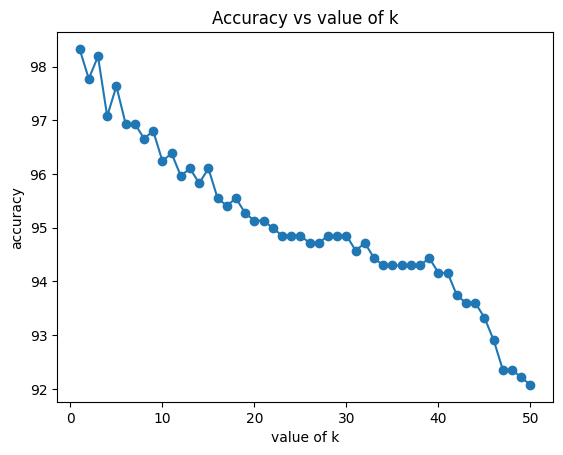

In [45]:
plt.plot(kth, knn_accuracy_scores, marker='o')
plt.xlabel("value of k")
plt.ylabel("accuracy")
plt.title("Accuracy vs value of k")
plt.show()

# part 3

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [49]:
X = dataset.iloc[:,:21]
y = dataset['Genus']

In [50]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Decision Tree accuracies
dt_accuracies = []
for depth in range(1, 16):
    dt_clf = DecisionTreeClassifier(max_depth=depth)
    dt_clf.fit(X_train_dt, y_train_dt)
    y_pred_dt = dt_clf.predict(X_test_dt)
    accuracy = accuracy_score(y_test_dt, y_pred_dt)
    dt_accuracies.append(accuracy)

In [53]:
# kNN accuracies
knn_accuracies = []
for k in range(1, 1001):
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train_knn, y_train_knn)
    y_pred_knn = knn_clf.predict(X_test_knn)
    accuracy = accuracy_score(y_test_knn, y_pred_knn)
    knn_accuracies.append(accuracy)

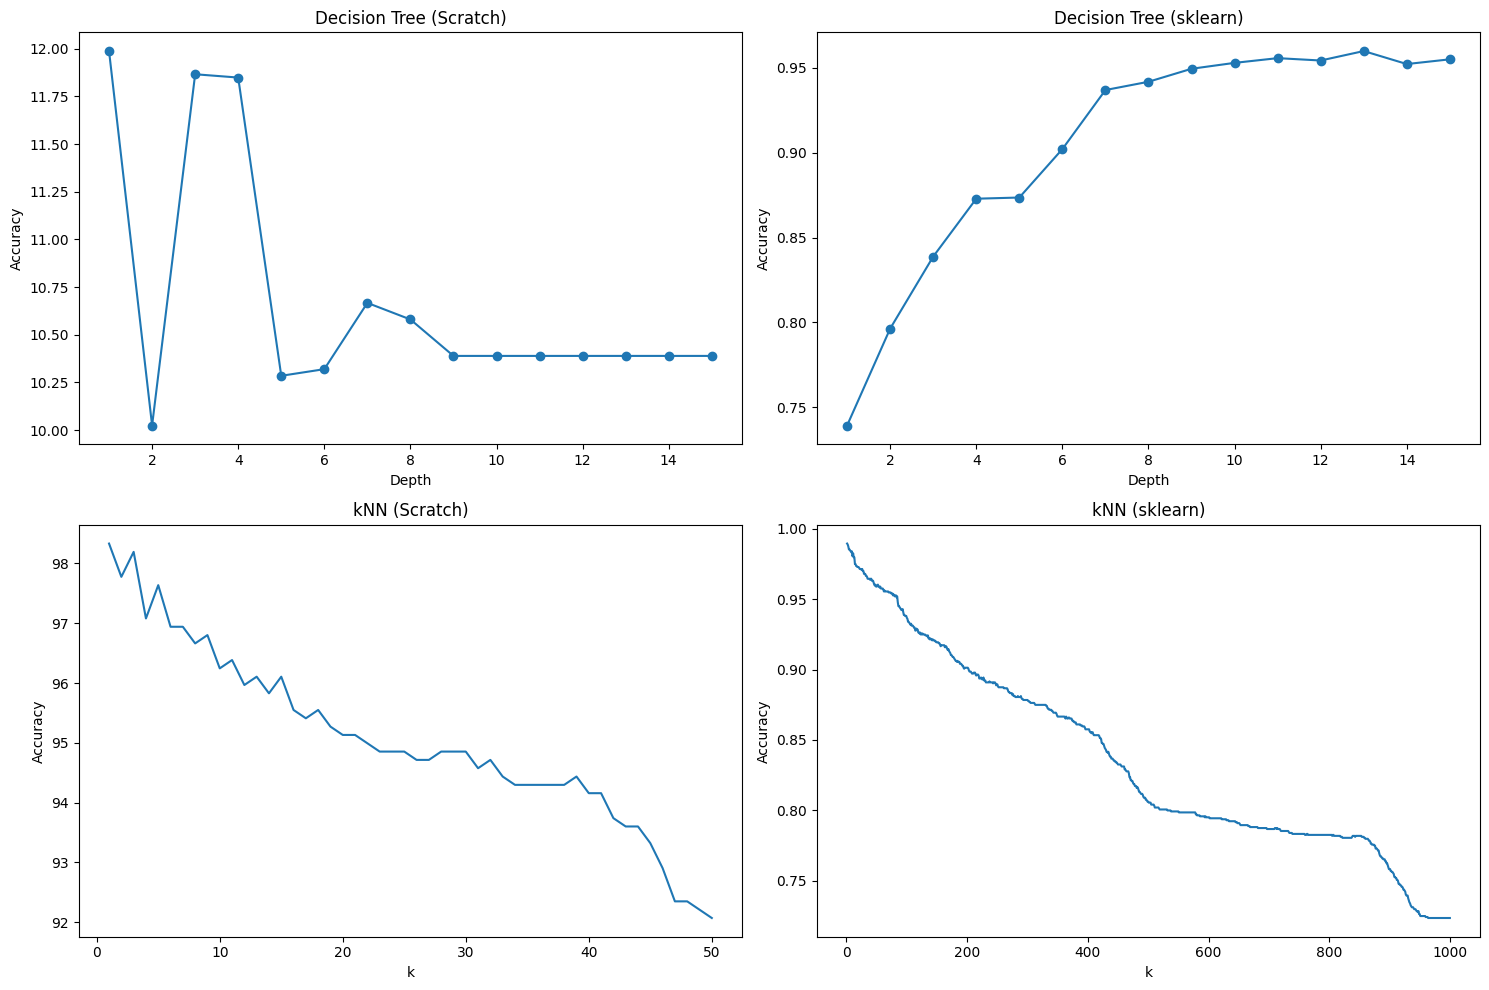

In [57]:


# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(range(1, 16), accuracy_scores, marker='o', linestyle='-')
axs[0, 0].set_title('Decision Tree (Scratch)')
axs[0, 0].set_xlabel('Depth')
axs[0, 0].set_ylabel('Accuracy')

axs[0, 1].plot(range(1, 16), dt_accuracies, marker='o', linestyle='-')
axs[0, 1].set_title('Decision Tree (sklearn)')
axs[0, 1].set_xlabel('Depth')
axs[0, 1].set_ylabel('Accuracy')

axs[1, 0].plot(range(1, 51), knn_accuracy_scores, marker=None, linestyle='-')
axs[1, 0].set_title('kNN (Scratch)')
axs[1, 0].set_xlabel('k')
axs[1, 0].set_ylabel('Accuracy')

axs[1, 1].plot(range(1, 1001), knn_accuracies, marker=None, linestyle='-')
axs[1, 1].set_title('kNN (sklearn)')
axs[1, 1].set_xlabel('k')
axs[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()